In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from textwrap import wrap
color_list = [
    "cornflowerblue",
    "orange",
    "deeppink",
    "blueviolet",
    "seagreen",
    "black",
]
linestyle_list=["-","--","-.",":"]
def findall(pattern, string):
    while True:
        match = re.search(pattern, string)
        if not match:
            break
        yield match.group(0)
        string = string[match.end():]

def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(6, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    # plt.savefig(file_name, bbox_inches="tight", pad_inches=0)
def decode_dict(d, encoding_used = 'utf-8'):
    return { k.decode(encoding_used) : (v.decode(encoding_used) if isinstance(v, bytes) else v) for k, v in d.items() }

In [2]:
lr =10
UNIT_G=1e9
MTU=1000
labels = {
    0: "(0,1KB]",
    1: "(1KB,10KB]",
    2: "(10KB,50KB]",
    3: "(50KB,inf)",
}
CC_DICT = {
    "dctcp": 8,
    # "dcqcn_paper_vwin": 1,
    # "hp": 3,
    # "timely_vwin": 7,
    # "powertcp": 9,
}
CC_LIST=list(CC_DICT.keys())

[('shard8_nflows2000_nhosts21_lr10Gbps', (0, 20), '_topo-pl-21_s0_i0'), ('shard8_nflows2000_nhosts21_lr10Gbps', (0, 20), '_topo-pl-21_s0_i2'), ('shard8_nflows2000_nhosts21_lr10Gbps', (0, 20), '_topo-pl-21_s0_i4'), ('shard8_nflows2000_nhosts21_lr10Gbps', (0, 20), '_topo-pl-21_s0_i15')]
spec=shard8_nflows2000_nhosts21_lr10Gbps,_topo-pl-21_s0_i0
sizes=40000
************************************************************************************************************************************************
shard8_nflows2000_nhosts21_lr10Gbps
spec=shard8_nflows2000_nhosts21_lr10Gbps,_topo-pl-21_s0_i2
sizes=40000
************************************************************************************************************************************************
shard8_nflows2000_nhosts21_lr10Gbps
spec=shard8_nflows2000_nhosts21_lr10Gbps,_topo-pl-21_s0_i4
sizes=40000
*******************************************************************************************************************************************

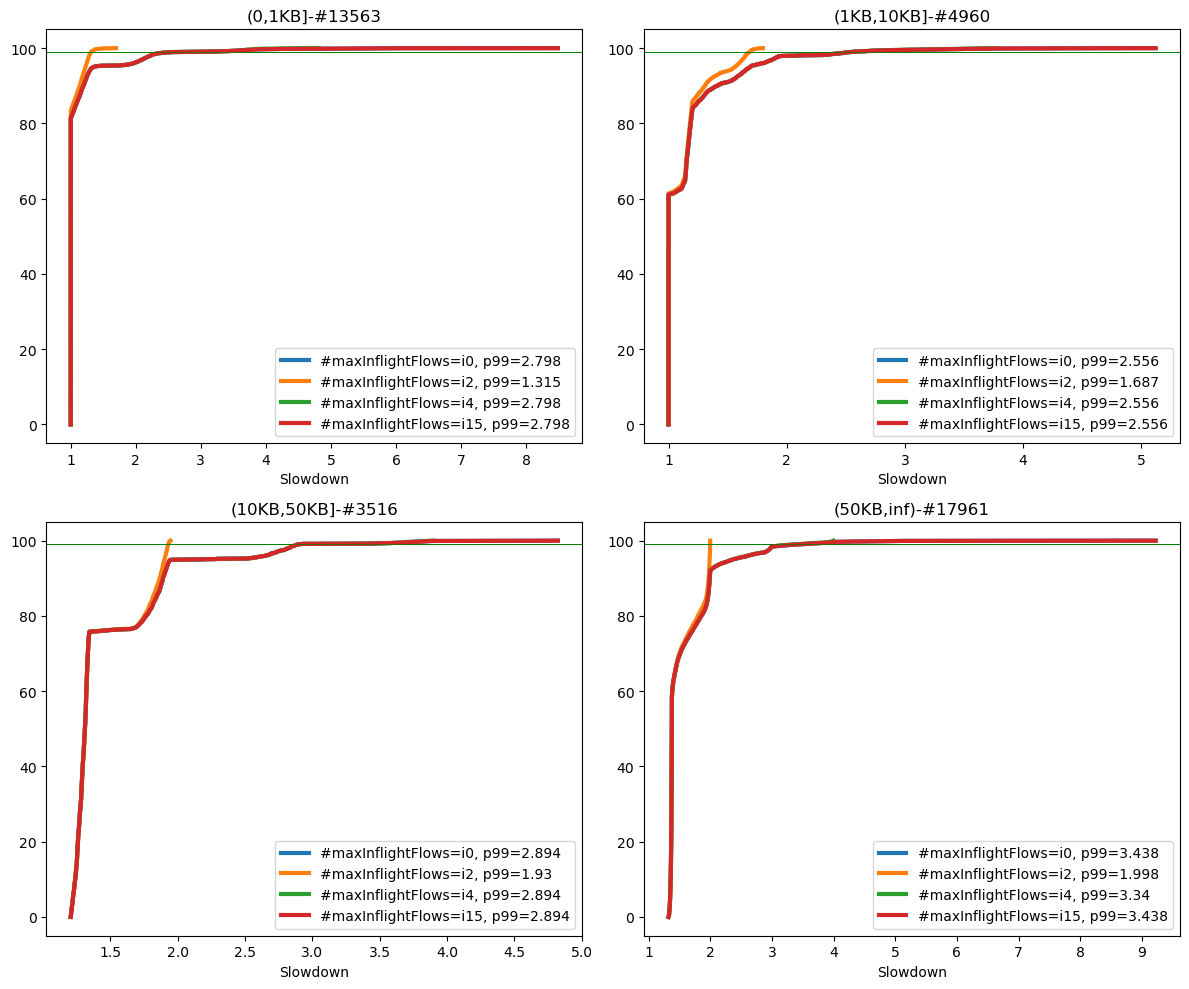

In [10]:

dir_input_synthetic="/data2/lichenni/path_perflow_busy_close_empirical"
dir_input_str=""

topo_type="_topo-pl-x_"
data_list_seeds = []
enable_longest_foreground_traffic=True
dir_input=dir_input_synthetic

data_list=[]
# for shard in np.arange(1):
for shard in [8]:
    for n_flows in [2000]:
        for n_hosts in [21]:
            # for dctcp_k in [5000,9000,15000,18000,22000,27000,30000]:
            # for shard_seed in np.arange(20):
            for shard_seed in [0]:
                for max_inflight_flows in [0, 2,4, 15]:
                    topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d_i%d"%(shard_seed,max_inflight_flows)
                    spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                    dir_input_tmp = f"{dir_input}/{spec}"
                    # stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                    # stats=np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True).item()
                    # print(f"stats={stats}")
                    # n_flows_total=stats["n_flows"]
                    fid = np.load(f"{dir_input}/{spec}/fid{topo_type_cur}.npy")
                    if len(fid)==len(set(fid))==(n_hosts-1)*n_flows and np.all(fid[:-1] <= fid[1:]):
                        data_list.append((spec,(0,n_hosts-1),topo_type_cur))
               
print(data_list)
# [FINAL]: NS3 vs MaxMinFair
fig_index=0
plt.figure(fig_index,figsize=(12, 10))

for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    max_inflight_flows=topo_type.split("_")[-1]
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=10*MTU
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
    flow_src_dst_flowsim = np.load(f"{dir_input_tmp}/fsd.npy")
    fats_flowsim = np.load(f"{dir_input_tmp}/fat.npy")
    
    sizes=sizes_flowsim[fid]
    flow_src_dst=flow_src_dst_flowsim[fid]
    fats=fats_flowsim[fid]
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    
    print(f"sizes={len(sizes)}")
    
    bins = np.digitize(sizes, [MTU, BDP, 5 * BDP])
    
    print("************************************************************************************************************************************************")
    print(f'{spec}')
    for i in range(len(labels)):
        gt = np.extract(bins==i, sldns)
        # print(f"p99 percentile: {np.percentile(gt,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        p99=np.round(np.percentile(gt,99),3)
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label=f"#maxInflightFlows={max_inflight_flows}, p99={p99}", linewidth=3)

        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend(loc='lower right')
        # plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1

In [8]:
DELAY_PROPAGATION_BASE = 1000  # 1us
LINK_TO_DELAY_DICT={
    3:np.array([0,0,0]),
    5:np.array([0,0,1*DELAY_PROPAGATION_BASE,0,0]),
    7:np.array([0,0,1*DELAY_PROPAGATION_BASE,2*DELAY_PROPAGATION_BASE,1*DELAY_PROPAGATION_BASE,0,0]),
}
HEADER_SIZE = 48
BYTE_TO_BIT = 8
def get_base_delay_pmn(sizes, n_links_passed, lr_bottleneck,flow_idx_target,flow_idx_nontarget_internal):
    pkt_head = np.clip(sizes, a_min=0, a_max=MTU)
    delay_propagation = DELAY_PROPAGATION_BASE * n_links_passed
    pkt_size=(pkt_head + HEADER_SIZE) * BYTE_TO_BIT
    delay_transmission = np.multiply(pkt_size / lr_bottleneck,flow_idx_target) + pkt_size / (lr_bottleneck*4)*(n_links_passed-2)-np.multiply(pkt_size / lr_bottleneck,flow_idx_nontarget_internal)

    return delay_propagation + delay_transmission

stats={'n_flows': 40000, 'n_flows_foreground': 1904, 'load_bottleneck_target': 0.7083510432704754, 'host_pair_list': [(0, 20), (1, 20), (2, 20), (3, 20), (4, 20), (5, 20), (6, 20), (7, 20), (8, 20), (9, 20), (10, 20), (11, 20), (12, 20), (13, 20), (14, 20), (15, 20), (16, 20), (17, 20), (18, 20), (19, 20)], 'load_candidate': 0.03541755216352378, 'size_dist_candidate': 'exp', 'size_sigma_candidate': 31678.007820125826, 'ias_sigma_candidate': 1.8442657485810172}
[('shard0_nflows2000_nhosts21_lr10Gbps', (0, 20), '_topo-pl-21_s0_i0')]
spec=shard0_nflows2000_nhosts21_lr10Gbps,_topo-pl-21_s0_i0
param_vec=[  0. 200.  18.   0.   1.  30.   0.   0.   0.   0.   0.   0.]
sizes=40000, fats=40000, fcts=40000, i_fcts=40000, sldns=40000
17.41s
************************************************************************************************************************************************
shard0_nflows2000_nhosts21_lr10Gbps
p99 percentile: 25.477139753197694
p99 percentile: 19.709103876020396
p99 percent

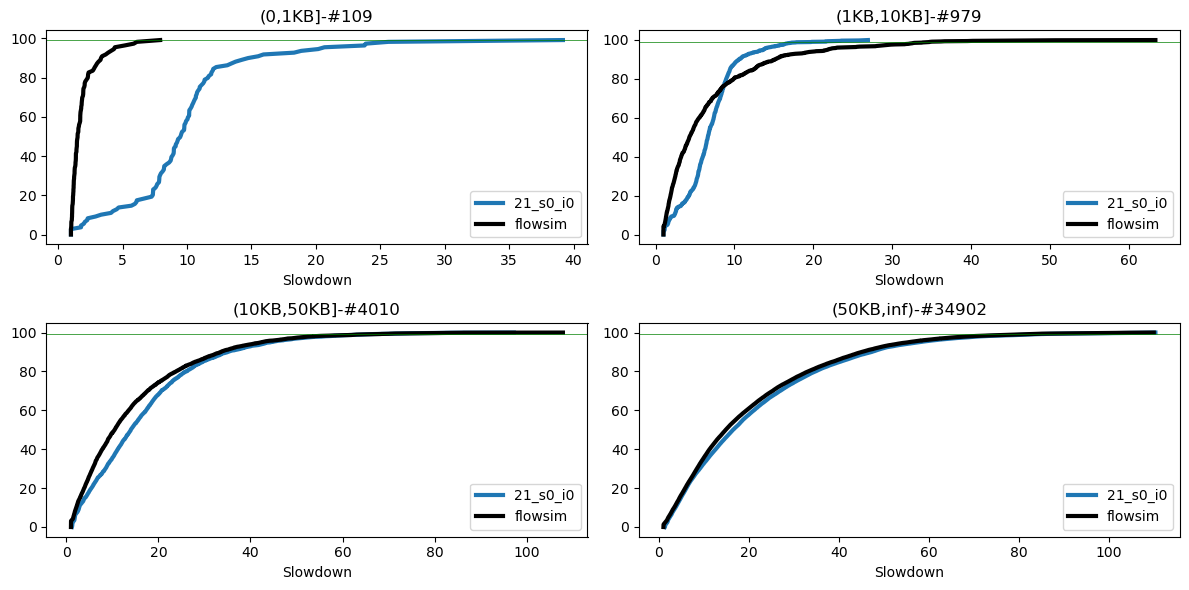

In [9]:

dir_input_synthetic="/data2/lichenni/perflow_link"
dir_input_str=''

topo_type="_topo-pl-x_"
data_list_seeds = []
enable_longest_foreground_traffic=True
dir_input=dir_input_synthetic

data_list=[]
# for shard in np.arange(1):
for shard in [0]:
    for n_flows in [2000]:
        for n_hosts in [21]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d_i0"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps{dir_input_str}"
                dir_input_tmp = f"{dir_input}/{spec}"
                # stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
                stats=np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True).item()
                print(f"stats={stats}")
                n_flows_total=stats["n_flows"]
                if enable_longest_foreground_traffic:
                    data_list.append((spec,(0,n_hosts-1),topo_type_cur))
               
print(data_list)
# [FINAL]: NS3 vs MaxMinFair
fig_index=0
plt.figure(fig_index,figsize=(12, 6))
for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=10*MTU
    dctcp_k_str=topo_type[9:]
    
    param_vec = np.load(f"{dir_input_tmp}/param{topo_type}.npy")
    print(f"param_vec={param_vec}")
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    sizes = np.load(f"{dir_input_tmp}/fsize.npy")[fid]
    fats = np.load(f"{dir_input_tmp}/fat.npy")[fid]
    flow_src_dst=np.load(f'{dir_input_tmp}/fsd.npy')[fid]
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    flow_idx_nontarget=~flow_idx_target
    flow_idx_nontarget_internal=np.logical_and(flow_src_dst[:,0]!=src_dst_pair_target[0], flow_src_dst[:,1]!=src_dst_pair_target[1])
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    # sldns = i_fcts
    print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")
    
    if spec_idx==0:
        n_links_passed=abs(flow_src_dst[:,0]-flow_src_dst[:,1])+flow_idx_nontarget+flow_idx_nontarget_internal
        lr_bottleneck=lr
        
        if n_hosts==21:
            n_hosts=3
            flow_src_dst[:,0]=0
            flow_src_dst[:,1]=2
        delay_extra=LINK_TO_DELAY_DICT[n_hosts][flow_src_dst[:,0]]+LINK_TO_DELAY_DICT[n_hosts][flow_src_dst[:,1]]
        base_delay=get_base_delay_pmn(sizes,n_links_passed,lr_bottleneck,flow_idx_target,flow_idx_nontarget_internal)+delay_extra
        i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT / lr_bottleneck + base_delay
        fcts_flowsim = np.load(f'{dir_input}/{spec}/fct_flowsim.npy')+ base_delay
        sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)
        # sldns_flowsim = i_fcts_flowsim

    bin = np.digitize(sizes, [MTU, BDP, 5 * BDP])

    print("************************************************************************************************************************************************")
    print(f'{spec}')
    for i in range(len(labels)):
        gt = np.extract(bin==i, sldns)
        if spec_idx==0:
            gt_flowsim = np.extract(bin==i, sldns_flowsim)
            sample_list_flowsim=np.arange(len(gt_flowsim))
            
        print(f"p99 percentile: {np.percentile(gt,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label=dctcp_k_str, linewidth=3)

        if spec_idx==0:
            plt.plot(np.sort(gt_flowsim)[sample_list_flowsim], (np.arange(len(gt_flowsim))/len(gt_flowsim)*100)[sample_list_flowsim], label="flowsim", linewidth=3,color='black')
            
        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        # plt.ylim([80, 100])
    plt.tight_layout()
fig_index+=1